# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pickle
import io
import numpy as np
from scipy.sparse import hstack, csr_matrix

In [4]:
with io.open('/content/drive/MyDrive/Colab Notebooks/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [5]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessed_data.csv', nrows=35000)

In [6]:
data['compound'] = [sid.polarity_scores(x)['compound'] for x in data['essay']]
data['neg'] = [sid.polarity_scores(x)['neg'] for x in data['essay']]
data['neu'] = [sid.polarity_scores(x)['neu'] for x in data['essay']]
data['pos'] = [sid.polarity_scores(x)['pos'] for x in data['essay']]

In [7]:
del sid

In [8]:
X = data.drop(['project_is_approved'], axis=1)
y = data['project_is_approved']

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

Creating respond encoding variables

In [10]:
train_respond = pd.concat([X_train, y_train], axis=1)

In [11]:
def response_variables(data,col):
  var_dict_total = dict(train_respond[col].value_counts())
  col_prob = {}
  for i in var_dict_total:
    col_prob[i] = round(((len(data.loc[(data[col] == i) & (data['project_is_approved'] == 0)])) / var_dict_total[i]),3)
  return col_prob

In [12]:
school_var_0 = response_variables(train_respond,"school_state")
teacher_var_0 = response_variables(train_respond,"teacher_prefix")
prj_cat_var_0 = response_variables(train_respond,"project_grade_category")
clean_cat_var_0 = response_variables(train_respond,"clean_categories")
clean_sub_var_0 = response_variables(train_respond,"clean_subcategories")

In [13]:
del train_respond

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

TfIdf encoding

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,3),max_features=10000)
vect_tfidf.fit(X_train['essay'])
X_train_essay_tfidf = vect_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vect_tfidf.transform(X_test['essay'].values)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

Categorical Features

In [14]:
def encoding_values(col,var):
  for i in var:
    X_train.loc[X_train[col] == i, [col]] = var[i]
  a = X_train[col]
  b = 1 - X_train[col]
  return a,b    

In [15]:
def encoding_values_test(col,var):
  col_var = dict(X_test[col].value_counts())
  not_inter = col_var.keys() - (col_var.keys() & var.keys())
  for i in var:
    if i not in not_inter:
      X_test.loc[X_test[col] == i, [col]] = var[i]

  for j in not_inter:
    X_test.loc[X_test[col] == j,[col]] = 0.5

  a = X_test[col]
  b = 1 - X_test[col]
  return a,b    

School State 

In [16]:
train_school_0,train_school_1 = encoding_values('school_state',school_var_0)
test_school_0,test_school_1 = encoding_values_test('school_state',school_var_0)

In [17]:
train_school_0 = csr_matrix(train_school_0.to_numpy(dtype=float).reshape(-1,1))
train_school_1 = csr_matrix(train_school_1.to_numpy(dtype=float).reshape(-1,1))
test_school_0 = csr_matrix(test_school_0.to_numpy(dtype=float).reshape(-1,1))
test_school_1 = csr_matrix(test_school_1.to_numpy(dtype=float).reshape(-1,1))

Teacher Prefix

In [18]:
train_teacher_0,train_teacher_1 = encoding_values('teacher_prefix',teacher_var_0)
test_teacher_0,test_teacher_1 = encoding_values_test('teacher_prefix',teacher_var_0)

In [19]:
train_teacher_0 = csr_matrix(train_teacher_0.to_numpy(dtype=float).reshape(-1,1))
train_teacher_1 = csr_matrix(train_teacher_1.to_numpy(dtype=float).reshape(-1,1))
test_teacher_0 = csr_matrix(test_teacher_0.to_numpy(dtype=float).reshape(-1,1))
test_teacher_1 = csr_matrix(test_teacher_1.to_numpy(dtype=float).reshape(-1,1))

Project Grade Category

In [20]:
train_prj_cat_0,train_prj_cat_1 = encoding_values('project_grade_category',prj_cat_var_0)
test_prj_cat_0,test_prj_cat_1 = encoding_values_test('project_grade_category',prj_cat_var_0)

In [21]:
train_prj_cat_0 = csr_matrix(train_prj_cat_0.to_numpy(dtype=float).reshape(-1,1))
train_prj_cat_1 = csr_matrix(train_prj_cat_1.to_numpy(dtype=float).reshape(-1,1))
test_prj_cat_0 = csr_matrix(test_prj_cat_0.to_numpy(dtype=float).reshape(-1,1))
test_prj_cat_1 = csr_matrix(test_prj_cat_1.to_numpy(dtype=float).reshape(-1,1))

Clean Categories

In [22]:
train_cat_0,train_cat_1 = encoding_values('clean_categories',clean_cat_var_0)
test_cat_0,test_cat_1 = encoding_values_test('clean_categories',clean_cat_var_0)

In [23]:
train_cat_0 = csr_matrix(train_cat_0.to_numpy(dtype=float).reshape(-1,1))
train_cat_1 = csr_matrix(train_cat_1.to_numpy(dtype=float).reshape(-1,1))
test_cat_0 = csr_matrix(test_cat_0.to_numpy(dtype=float).reshape(-1,1))
test_cat_1 = csr_matrix(test_cat_1.to_numpy(dtype=float).reshape(-1,1))

Clean SubCategories

In [24]:
train_subcat_0,train_subcat_1 = encoding_values('clean_subcategories',clean_sub_var_0)
test_subcat_0,test_subcat_1 = encoding_values_test('clean_subcategories',clean_sub_var_0)

In [25]:
train_subcat_0 = csr_matrix(train_subcat_0.to_numpy(dtype=float).reshape(-1,1))
train_subcat_1 = csr_matrix(train_subcat_1.to_numpy(dtype=float).reshape(-1,1))
test_subcat_0 = csr_matrix(test_subcat_0.to_numpy(dtype=float).reshape(-1,1))
test_subcat_1 = csr_matrix(test_subcat_1.to_numpy(dtype=float).reshape(-1,1))

In [26]:
del school_var_0, teacher_var_0 , prj_cat_var_0, clean_cat_var_0, clean_sub_var_0 

Numerical Features

In [27]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

Price

In [28]:
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

In [29]:
X_train_price_norm = csr_matrix(X_train_price_norm.reshape(-1,1))
X_test_price_norm = csr_matrix(X_test_price_norm.reshape(-1,1))

Teacher's Previously Submitted Project

In [30]:
X_train_prev_sub_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_sub_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

In [31]:
X_train_prev_sub_norm = csr_matrix(X_train_prev_sub_norm.reshape(-1,1))
X_test_prev_sub_norm = csr_matrix(X_test_prev_sub_norm.reshape(-1,1))

In [32]:
del data, normalizer

Set 1

In [34]:
X_train_1 = hstack([X_train_essay_tfidf,train_school_0,train_school_1,train_teacher_0,train_teacher_1,train_prj_cat_0,train_prj_cat_1,train_cat_0,train_cat_1,train_subcat_0,train_subcat_1,X_train_price_norm,X_train_prev_sub_norm,X_train['compound'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['pos'].values.reshape(-1,1)])
X_test_1  = hstack([X_test_essay_tfidf,test_school_0,test_school_1,test_teacher_0,test_teacher_1,test_prj_cat_0,test_prj_cat_1,test_cat_0,test_cat_1,test_subcat_0,test_subcat_1,X_test_price_norm,X_test_prev_sub_norm,X_test['compound'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['pos'].values.reshape(-1,1)])

In [35]:
del X_train_essay_tfidf,train_school_0,train_school_1,train_teacher_0,train_teacher_1,train_prj_cat_0,train_prj_cat_1,train_cat_0,train_cat_1,train_subcat_0,train_subcat_1,X_train_price_norm,X_train_prev_sub_norm

In [36]:
del X_test_essay_tfidf,test_school_0,test_school_1,test_teacher_0,test_teacher_1,test_prj_cat_0,test_prj_cat_1,test_cat_0,test_cat_1,test_subcat_0,test_subcat_1,X_test_price_norm,X_test_prev_sub_norm

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns 

In [38]:
model = GradientBoostingClassifier()
parameters = {'learning_rate':[0.001, 0.01, 0.1, 10],'n_estimators':[50, 100, 150, 200]}
clf = RandomizedSearchCV(model, parameters, cv=5, n_iter=5 ,scoring='roc_auc',return_train_score=True)
clf.fit(X_train_1,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   return_train_score=True, scoring='roc_auc')

In [39]:
results = pd.DataFrame.from_dict(clf.cv_results_)

In [40]:
del clf,model,parameters

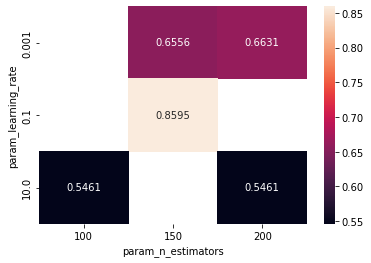

In [41]:
max_scores = results.groupby(['param_learning_rate', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')

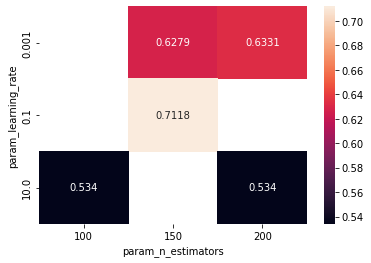

In [42]:
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

The best feature is learning rate = 0.1 and n_estimators = 150

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

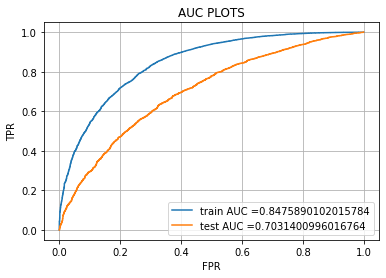

In [40]:
model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150)
model.fit(X_train_1,y_train)

y_train_pred = model.predict_proba(X_train_1)
y_test_pred = model.predict_proba(X_test_1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:,1])
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

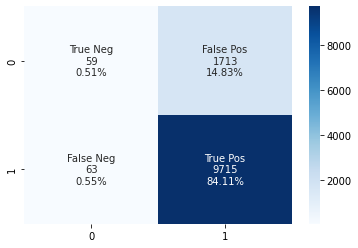

In [41]:
from sklearn.metrics import confusion_matrix

model.fit(X_train_1,y_train)
y_test_pred = model.predict(X_test_1)

cf_matrix = confusion_matrix(y_test, y_test_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
        
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, cmap='Blues',fmt='')

In [ ]:
del X_train_1,X_test_1

Set 2

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect_tfidf = TfidfVectorizer()
vect_tfidf.fit(X_train['essay'])
dict_tfidf = dict(zip(vect_tfidf.get_feature_names_out(),list(vect_tfidf.idf_)))
tfidf_words = set(vect_tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
def tfidf_w2v(preprocessed_essay):
  tfidf_w2v_vectors = []
  for sentence in preprocessed_essay:
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
      if(word in glove_words) and (word in tfidf_words):
        vec = model[word]
        tf_idf = dict_tfidf[word]*(sentence.count(word)/len(sentence.split()))
        vector += (vec*tf_idf)
        tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors 

In [37]:
X_train_essay_w2v = tfidf_w2v(X_train['essay'].values)
X_test_essay_w2v = tfidf_w2v(X_test['essay'].values)

In [38]:
del glove_words,tfidf_words,dict_tfidf,vect_tfidf

In [39]:
X_train_2 = hstack([X_train_essay_w2v,train_school_0,train_school_1,train_teacher_0,train_teacher_1,train_prj_cat_0,train_prj_cat_1,train_cat_0,train_cat_1,train_subcat_0,train_subcat_1,X_train_price_norm,X_train_prev_sub_norm,X_train['compound'].values.reshape(-1,1),X_train['neg'].values.reshape(-1,1),X_train['neu'].values.reshape(-1,1),X_train['pos'].values.reshape(-1,1)])
X_test_2  = hstack([X_test_essay_w2v,test_school_0,test_school_1,test_teacher_0,test_teacher_1,test_prj_cat_0,test_prj_cat_1,test_cat_0,test_cat_1,test_subcat_0,test_subcat_1,X_test_price_norm,X_test_prev_sub_norm,X_test['compound'].values.reshape(-1,1),X_test['neg'].values.reshape(-1,1),X_test['neu'].values.reshape(-1,1),X_test['pos'].values.reshape(-1,1)])

Set 2 hyperparameter tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns 

In [41]:
model = GradientBoostingClassifier()
parameters = {'learning_rate':[0.001, 0.01, 0.1, 10],'n_estimators':[50, 100, 150, 200]}
clf = RandomizedSearchCV(model, parameters, cv=5, n_iter=5 ,scoring='roc_auc',return_train_score=True)
clf.fit(X_train_2,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   return_train_score=True, scoring='roc_auc')

In [42]:
results = pd.DataFrame.from_dict(clf.cv_results_)

In [43]:
del clf,model,parameters

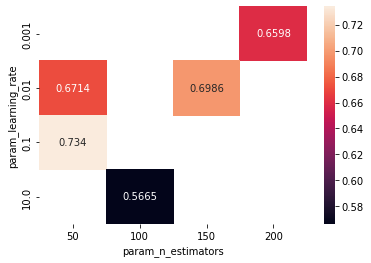

In [44]:
max_scores = results.groupby(['param_learning_rate', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')

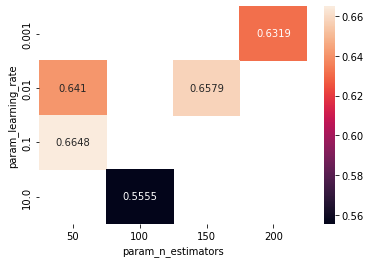

In [45]:
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')

The best feature is learning rate = 0.1 and n_estimators = 50

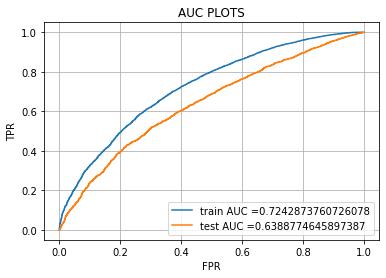

In [48]:
model = GradientBoostingClassifier(learning_rate=0.1,n_estimators=50)
model.fit(X_train_2,y_train)

y_train_pred = model.predict_proba(X_train_2)
y_test_pred = model.predict_proba(X_test_2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:,1])
test_fpr, test_tpr, ts_thresholds = roc_curve(y_test, y_test_pred[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.grid()
plt.show()

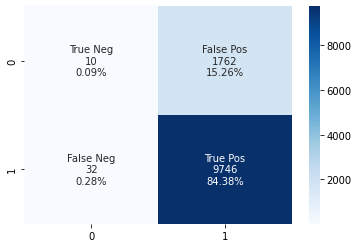

In [50]:
from sklearn.metrics import confusion_matrix
model.fit(X_train_2,y_train)
y_test_pred = model.predict(X_test_2)

cf_matrix = confusion_matrix(y_test, y_test_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
        
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, cmap='Blues',fmt='')

In [51]:
del X_train_2, X_test_2

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [57]:
from prettytable import PrettyTable
x = PrettyTable()

In [58]:
x.field_names = ["Vectorizer", "Model", "learning_rate", "n_estimators", "AUC"]
x.add_row(["TFIDf", "Brute", 0.1, 150, 0.70])
x.add_row(["W2V", "Brute", 0.1, 50, 0.63])

In [59]:
x

Vectorizer,Model,learning_rate,n_estimators,AUC
TFIDf,Brute,0.1,150,0.7
W2V,Brute,0.1,50,0.63
